# Insurance Claim Prediction Notebook

### Import Libraries

Start by importing the required libraries.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import cohen_kappa_score,precision_score, recall_score,f1_score,roc_auc_score,RocCurveDisplay,roc_curve,precision_recall_curve,confusion_matrix,ConfusionMatrixDisplay,accuracy_score,classification_report

In [2]:
warnings.filterwarnings('ignore')

### Import Datasets

Import the datasets. Input data files are available in the "/dataset/.." directory.

In [3]:
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

# Data Analysis

In [4]:
train_data.head().T

,0,1,2,3,4
policy_id,ID00001,ID00002,ID00003,ID00004,ID00005
policy_tenure,0.515874,0.672619,0.84111,0.900277,0.596403
age_of_car,0.05,0.02,0.02,0.11,0.11
age_of_policyholder,0.644231,0.375,0.384615,0.432692,0.634615
area_cluster,C1,C2,C3,C4,C5
population_density,4990,27003,4076,21622,34738
make,1,1,1,1,2
segment,A,A,A,C1,A
model,M1,M1,M1,M2,M3
fuel_type,CNG,CNG,CNG,Petrol,Petrol


Printing the shape of the dataset.

In [5]:
train_data.shape, test_data.shape

((58592, 44), (39063, 43))

The train dataset contains 58592 rows and 44 columns.
<br>
The test dataset contains 39063 rows and 43 columns.
<br>
The missing column in the test dataset is the "is_claim" attribute.

---

### Data Description

Check what type of data we are analysing.

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

This information shows that the dataset has no null-values.
<br>
There are 16 numerical features and 28 categorical features.

### Data Simplification

In [7]:
train = train_data.copy()
test = test_data.copy()

Drop unnecessary columns. This columns don't add any necessary value to the analyisis.

In [8]:
train.drop(['policy_id','make','model'], axis=1, inplace=True)

Correct some types in the datasets

In [9]:
train['airbags'] = train['airbags'].astype('object')
train['cylinder'] = train['cylinder'].astype('object')
train['gear_box'] = train['gear_box'].astype('object')
train['ncap_rating'] = train['ncap_rating'].astype('object')
train['is_claim'] = train['is_claim'].astype('object')

test['airbags'] = test['airbags'].astype('object')
test['cylinder'] = test['cylinder'].astype('object')
test['gear_box'] = test['gear_box'].astype('object')
test['ncap_rating'] = test['ncap_rating'].astype('object')

In order to compare some data, we found it easier to divide them and create new columns.

In [10]:
train['max_torque_nm'] = train['max_torque'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*Nm)").astype('float64')
train['max_torque_rpm'] = train['max_torque'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*rpm)").astype('float64')
train['max_power_bhp'] = train['max_power'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*bhp)").astype('float64')
train['max_power_rpm'] = train['max_power'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*rpm)").astype('float64')
train.drop(['max_torque', 'max_power'], axis=1, inplace=True)

test['max_torque_nm'] = test['max_torque'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*Nm)").astype('float64')
test['max_torque_rpm'] = test['max_torque'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*rpm)").astype('float64')
test['max_power_bhp'] = test['max_power'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*bhp)").astype('float64')
test['max_power_rpm'] = test['max_power'].str.extract(r"([-+]?[0-9]*\.?[0-9]+)(?=\s*rpm)").astype('float64')
test.drop(['max_torque', 'max_power'], axis=1, inplace=True)

In order to analyse some data, some values need to be normalized, such as 'area_cluster' and 'engine_type'.

In [11]:
cluster = train['area_cluster'].value_counts(normalize=True).to_dict()
train['area_cluster'] = train['area_cluster'].map(cluster)

engine = train['engine_type'].value_counts(normalize=True).to_dict()
train['engine_type'] = train['engine_type'].map(engine)

cluster = test['area_cluster'].value_counts(normalize=True).to_dict()
test['area_cluster'] = test['area_cluster'].map(cluster)

engine = test['engine_type'].value_counts(normalize=True).to_dict()
test['engine_type'] = test['engine_type'].map(engine)

### Categorical Features

In [12]:
categorical = train.select_dtypes(include=object).columns
categorical

Index(['segment', 'fuel_type', 'airbags', 'is_esc', 'is_adjustable_steering',
       'is_tpms', 'is_parking_sensors', 'is_parking_camera',
       'rear_brakes_type', 'cylinder', 'transmission_type', 'gear_box',
       'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper',
       'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'is_claim'],
      dtype='object')

### Numerical Features

In [13]:
numerical = train.select_dtypes(include=np.number).columns
numerical

Index(['policy_tenure', 'age_of_car', 'age_of_policyholder', 'area_cluster',
       'population_density', 'engine_type', 'displacement', 'turning_radius',
       'length', 'width', 'height', 'gross_weight', 'max_torque_nm',
       'max_torque_rpm', 'max_power_bhp', 'max_power_rpm'],
      dtype='object')

View the statistical summary of numerical variables.

In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
policy_tenure,58592.0,0.611246,0.414156,0.002735,0.210250,0.573792,1.039104,1.396641
age_of_car,58592.0,0.069424,0.056721,0.000000,0.020000,0.060000,0.110000,1.000000
age_of_policyholder,58592.0,0.469420,0.122886,0.288462,0.365385,0.451923,0.548077,1.000000
area_cluster,58592.0,0.111577,0.076164,0.001860,0.053847,0.104127,0.125307,0.233035
population_density,58592.0,18826.858667,17660.174792,290.000000,6112.000000,8794.000000,27003.000000,73430.000000
engine_type,58592.0,0.189686,0.089177,0.006195,0.071221,0.235117,0.255120,0.255120
displacement,58592.0,1162.355851,266.304786,796.000000,796.000000,1197.000000,1493.000000,1498.000000
turning_radius,58592.0,4.852893,0.228061,4.500000,4.600000,4.800000,5.000000,5.200000
length,58592.0,3850.476891,311.457119,3445.000000,3445.000000,3845.000000,3995.000000,4300.000000
width,58592.0,1672.233667,112.089135,1475.000000,1515.000000,1735.000000,1755.000000,1811.000000


### Missing Values

In order to analyse both train and test dataset, we need to check if there are any missing values.

Train data:

In [15]:
len([x for x in train.isnull().sum() if x!=0])

0

Test data:

In [16]:
len([x for x in test.isnull().sum() if x!=0])

0

### Duplicated Values

Verify if there are any duplicated values.

Train data:

In [17]:
train.duplicated().sum()

0

Train data:

In [18]:
test.duplicated().sum()

0

### Target Distribution

How many policyholders filed a claim in the last 6 months?

In [19]:
train.is_claim.value_counts()

0    54844
1     3748
Name: is_claim, dtype: int64

The values for the target column are imbalanced.

---

# Features

### Univariate Analysis

Focusing on each variable in isolation.

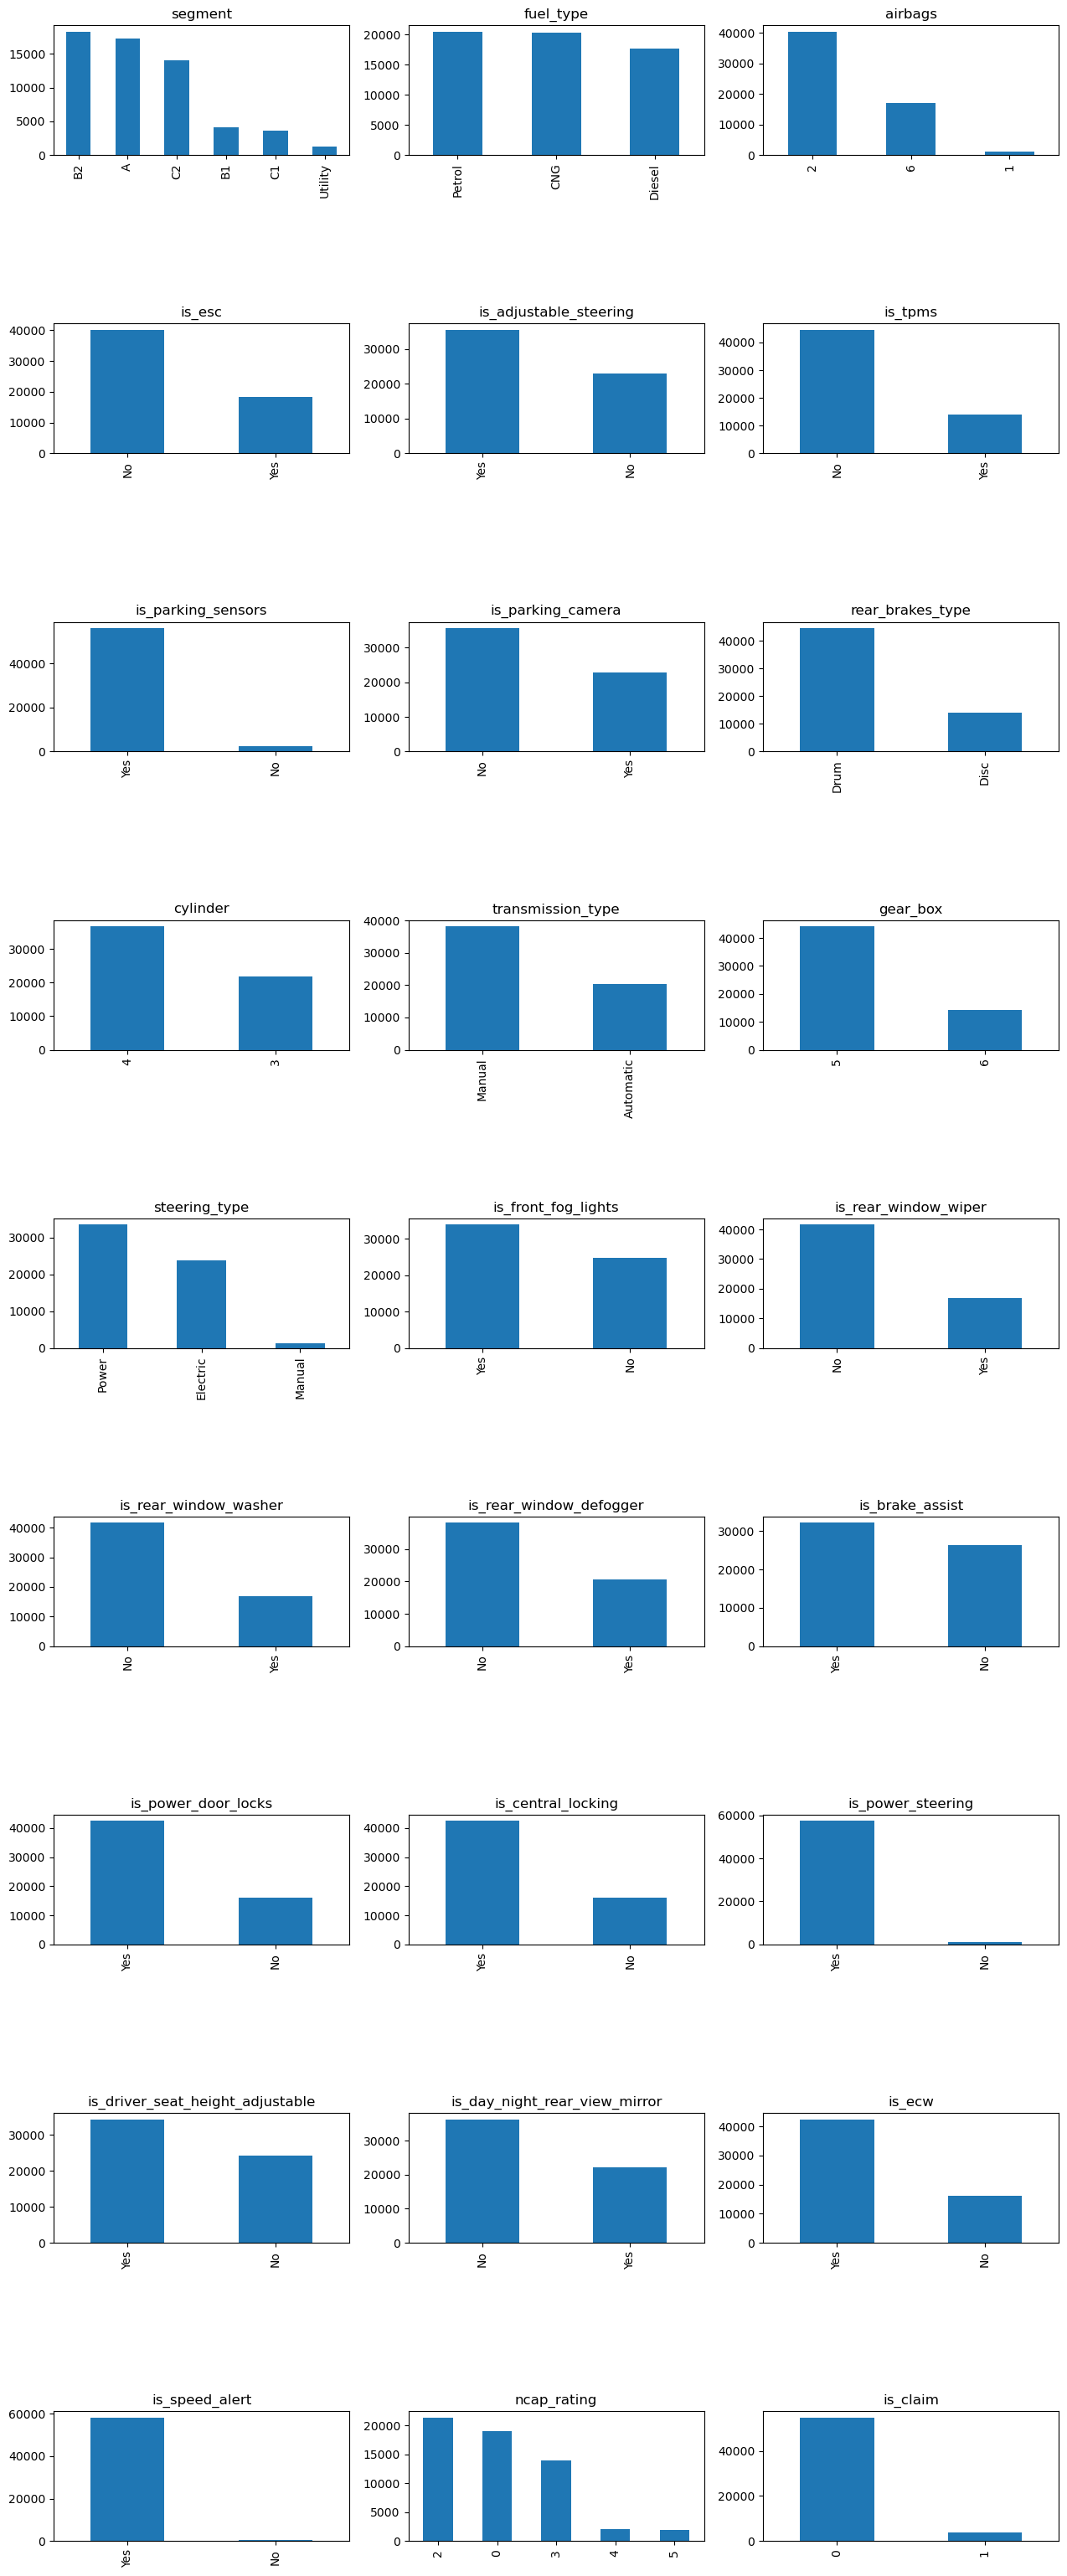

In [20]:
j=1
for i in categorical:
    plt.subplots_adjust(left=None, bottom=1, right=2,top=8, wspace=None, hspace=1.3)
    plt.subplot(10,3,j)
    train_data[i].value_counts().plot(kind='bar')
    plt.title(i)
    j+=1
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Some numerical features cannot be analysed through graphs, since they are car features, such as power and torque, it's too relative too evaluate them.

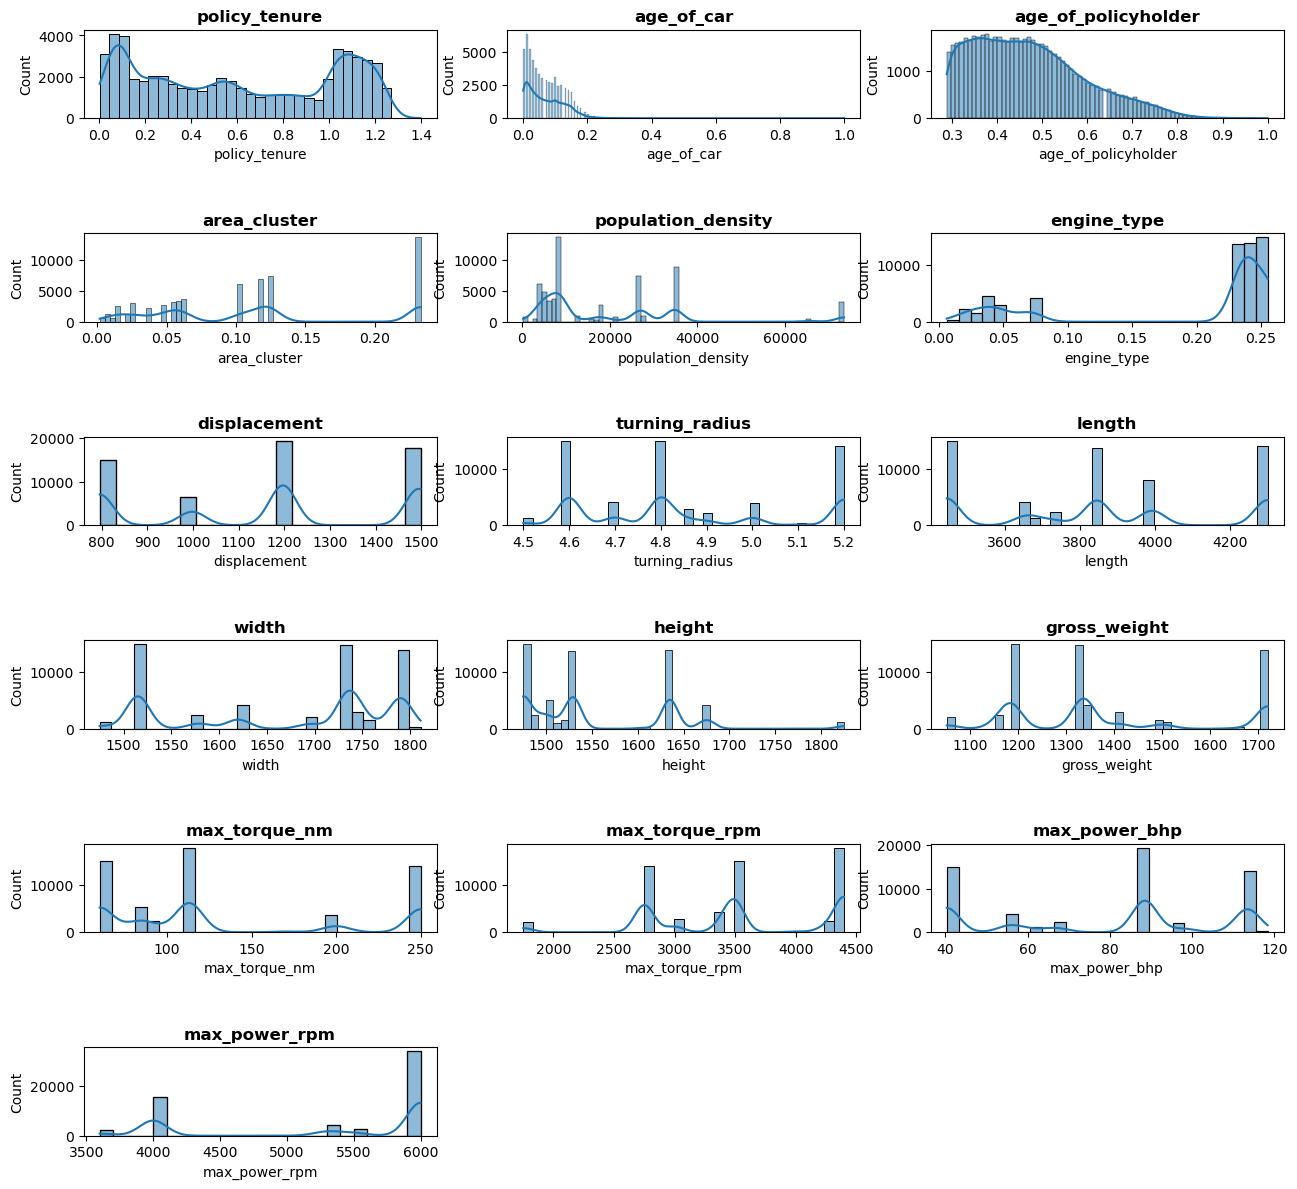

In [21]:
j=1
for i in numerical:
    plt.subplots_adjust(left=None, bottom=1, right=2, top=5, wspace=None, hspace=1.3)
    plt.subplot(10,3,j)
    sns.histplot(train[i], kde=True)
    plt.title(i, weight='bold')
    j+=1
plt.tight_layout()
plt.show()

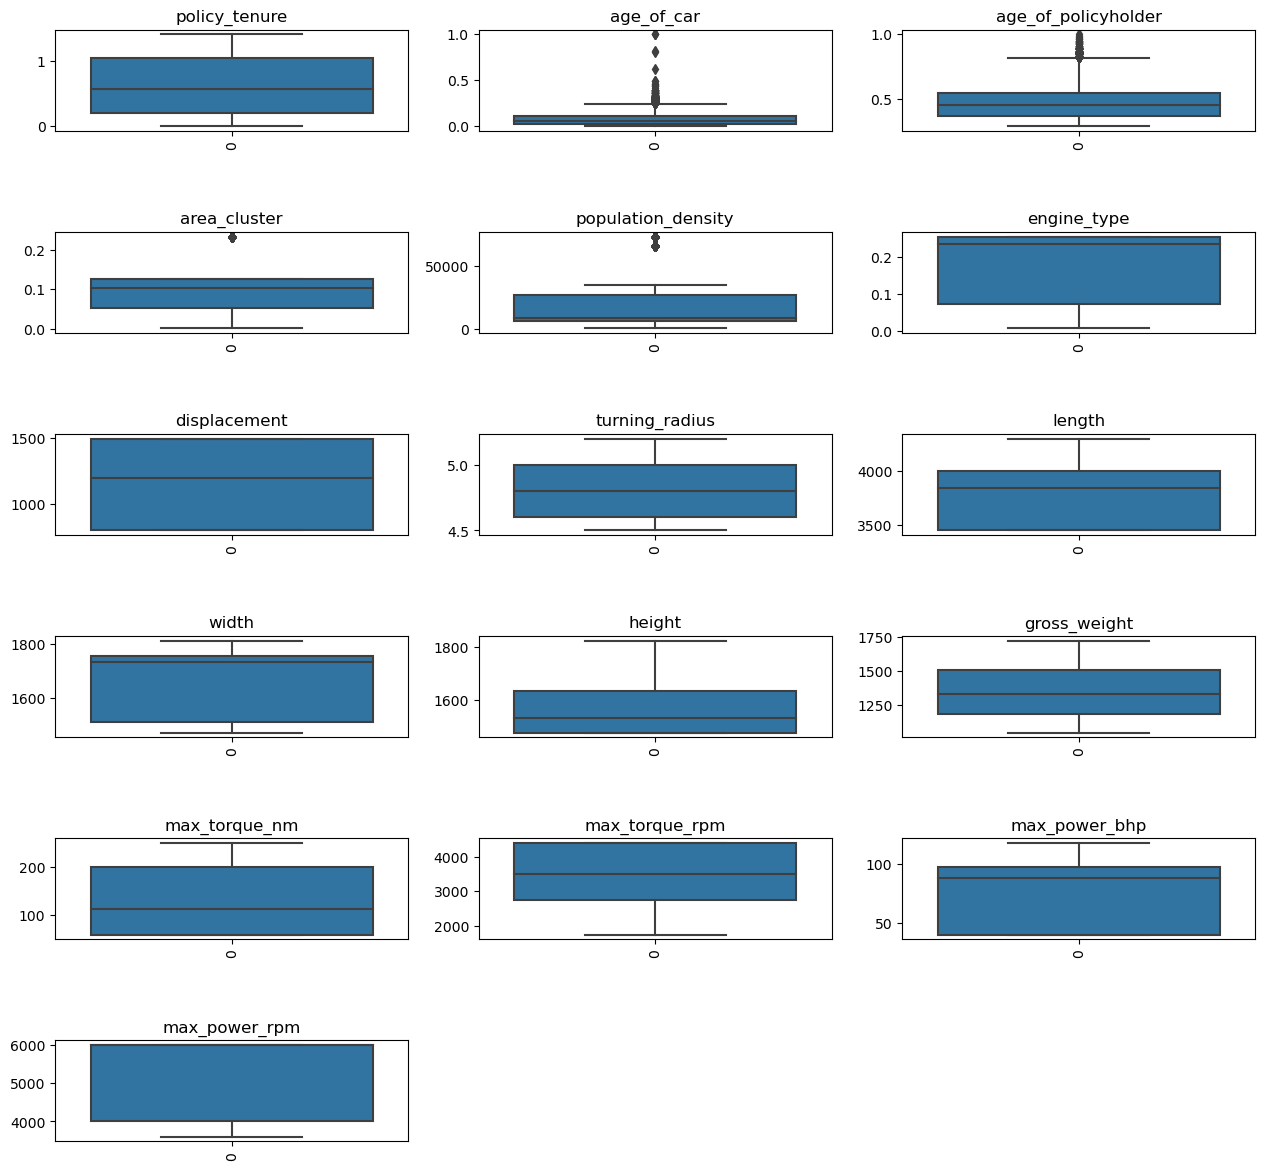

In [22]:
j=1
for i in numerical:
    plt.subplots_adjust(left=None, bottom=1, right=2, top=5, wspace=None, hspace=1)
    plt.subplot(10,3,j)
    sns.boxplot(train[i])
    plt.title(i)
    j=j+1
    plt.xticks(rotation=90)
    
plt.tight_layout()    
plt.show()

### Bivariate Analysis

Comparing each variable to the is_claim column.

In [23]:
bdata = ['area_cluster', 'population_density', 'segment', 'fuel_type', 'engine_type', 'airbags',
         'rear_brakes_type', 'displacement', 'cylinder', 'transmission_type', 'gear_box', 'steering_type',
         'turning_radius', 'length', 'width', 'height', 'gross_weight', 'ncap_rating']

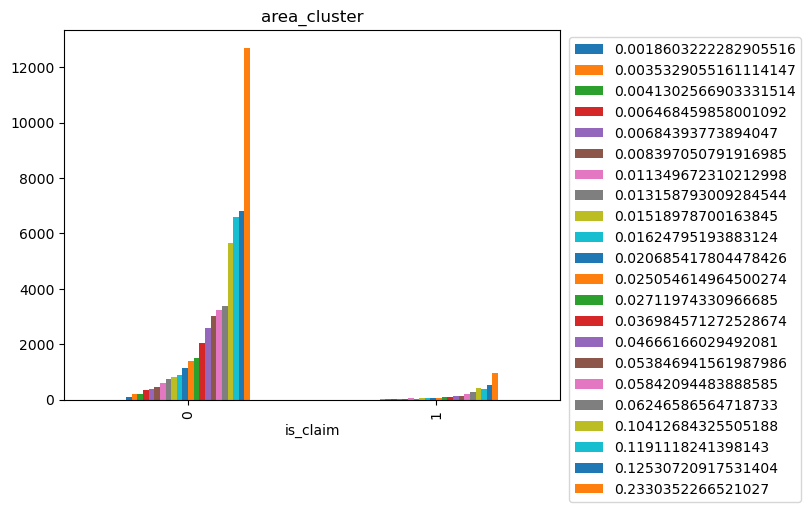

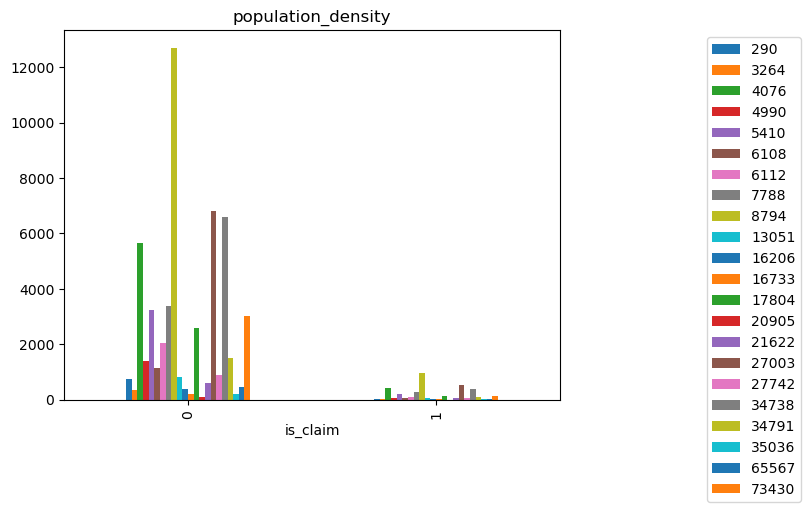

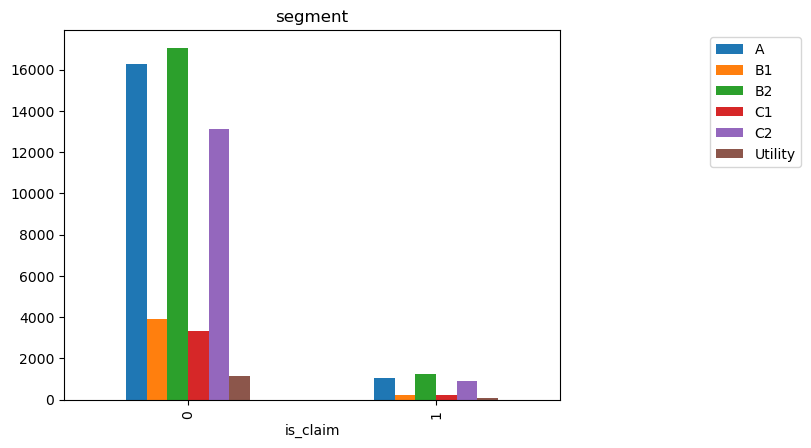

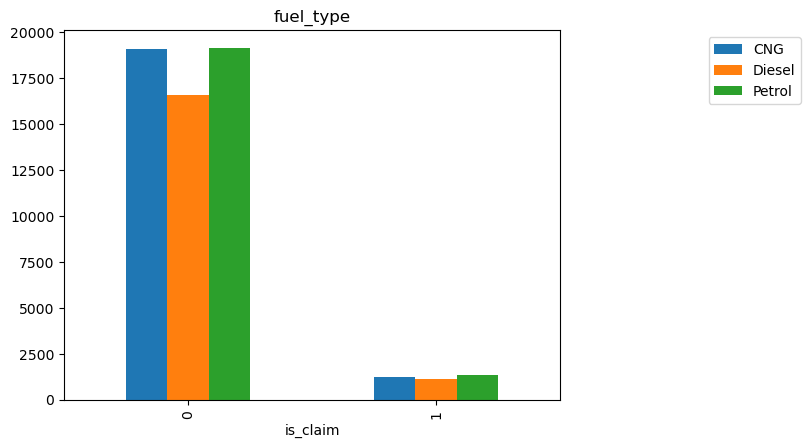

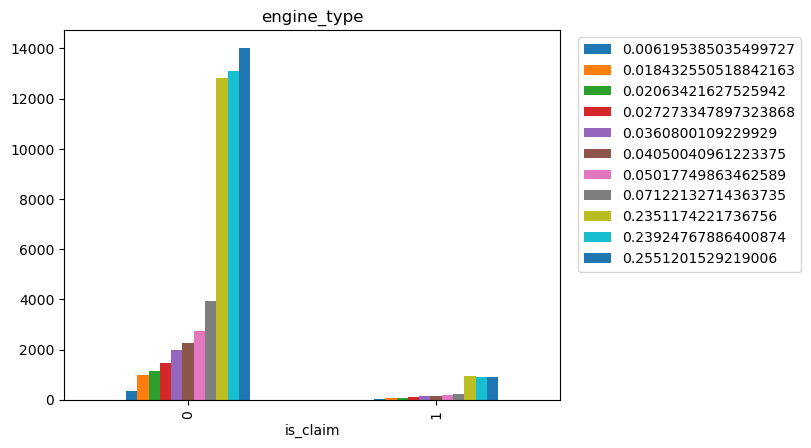

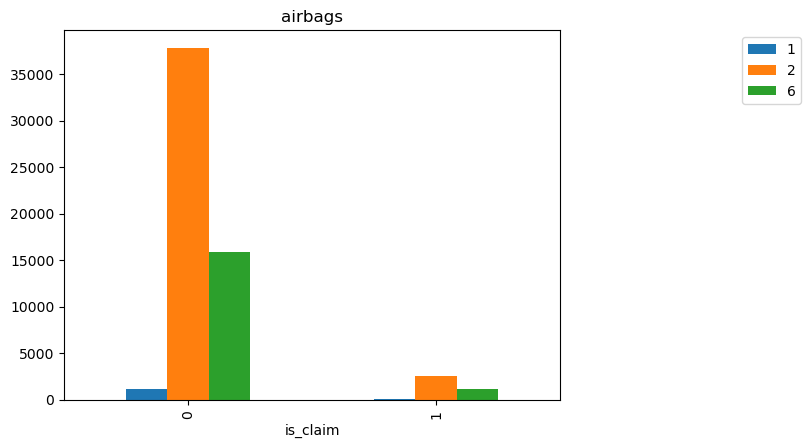

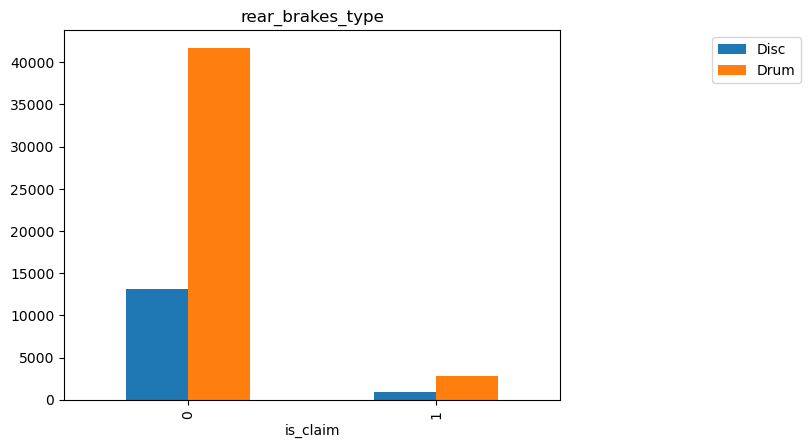

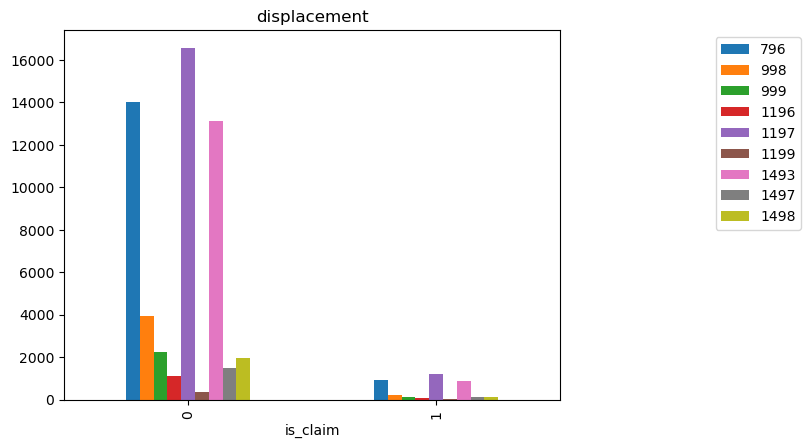

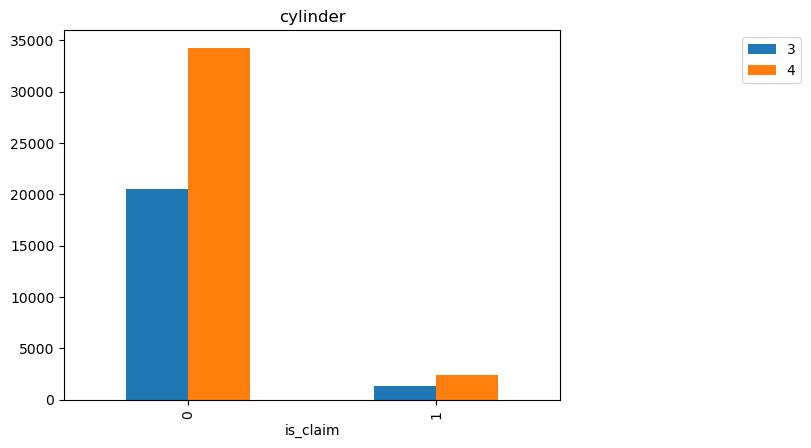

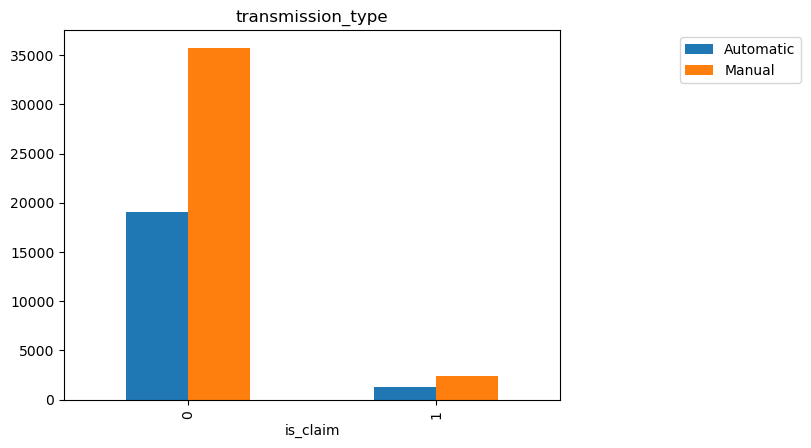

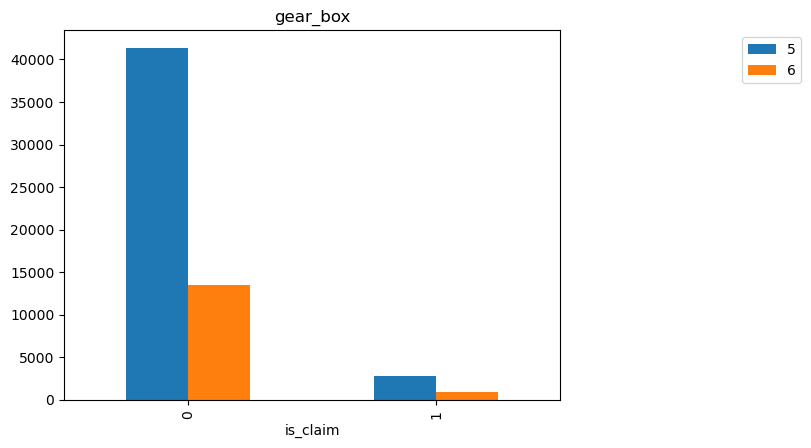

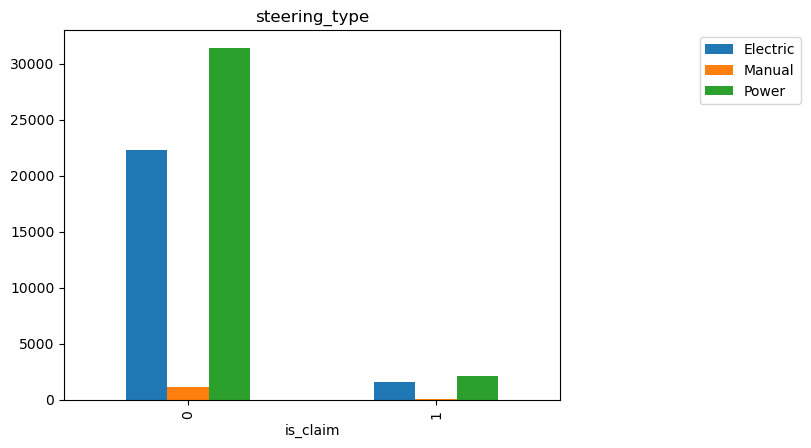

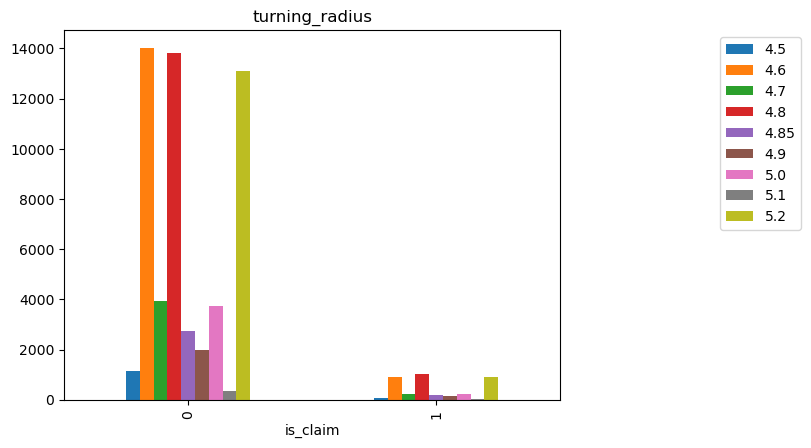

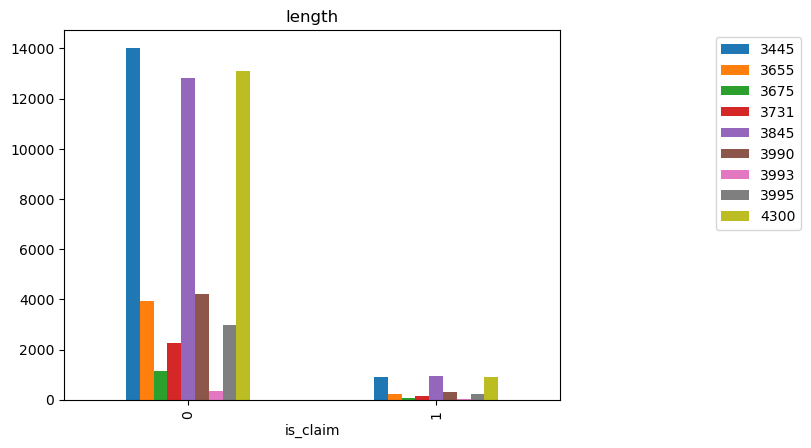

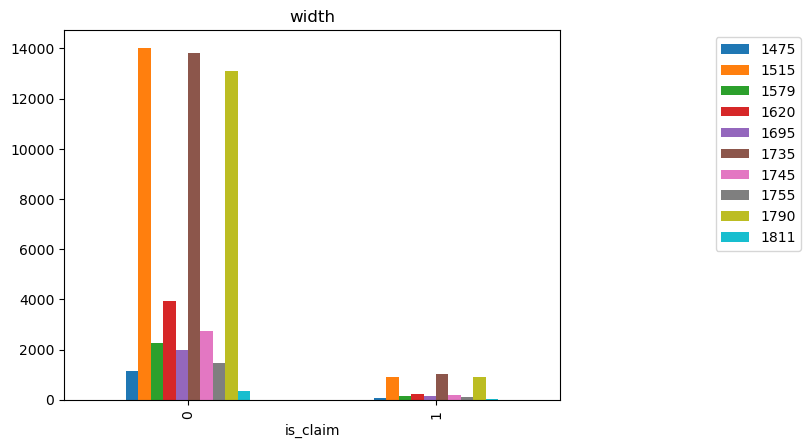

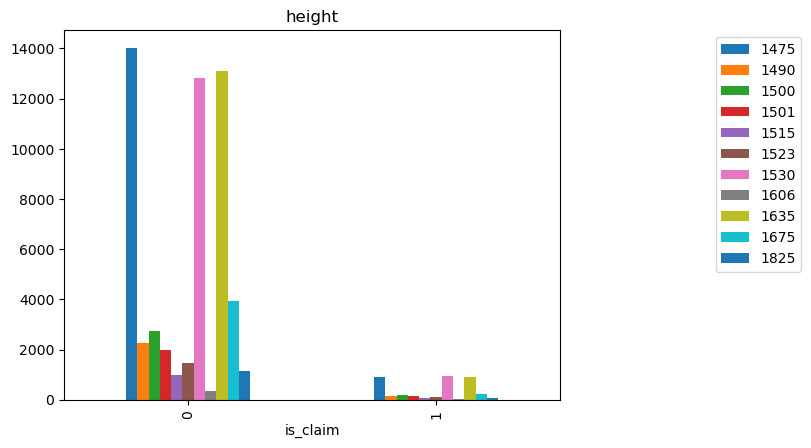

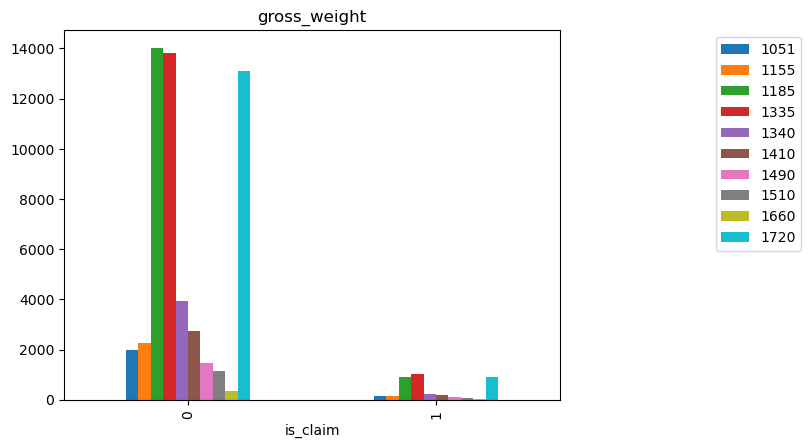

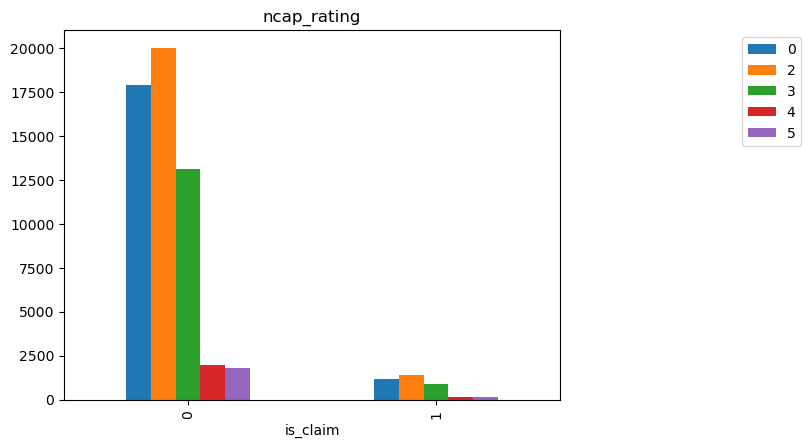

In [24]:
j=1
for i in bdata:
    pd.crosstab(train.is_claim, train[i]).plot(kind='bar')
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    plt.title(i)
    j+=1
    plt.xticks(rotation=90)
#plt.tight_layout()    
plt.show()

# Data Preprocessing

### Outliers

Considering that the attribute 'age_of_car' is relevant, we can use it to possibly detect outliers.

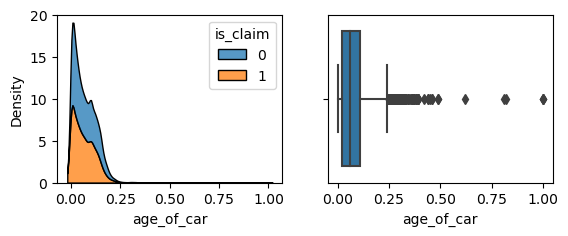

In [25]:
plt.subplot(2,2,1)
sns.kdeplot(data=train, x="age_of_car", hue="is_claim", multiple="stack", common_norm=False)

plt.subplot(2,2,2)
sns.boxplot(x='age_of_car', data=train)
plt.show()

Remove the outliers.

In [26]:
train.shape

(58592, 43)

In [27]:
train = train[train.age_of_car <= train.age_of_car.quantile(0.995)]

In [28]:
train.shape

(58323, 43)

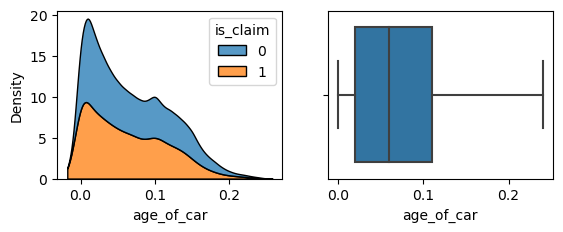

In [29]:
plt.subplot(2,2,1)
sns.kdeplot(data=train, x="age_of_car", hue="is_claim", multiple="stack", common_norm=False)

plt.subplot(2,2,2)
sns.boxplot(x='age_of_car', data=train)
plt.show()

### Scaling

In [30]:
scaler = StandardScaler()
train.loc[:,numerical.drop('age_of_car')] = scaler.fit_transform(pd.DataFrame(train.loc[:,numerical.drop('age_of_car')]))

<Axes: xlabel='age_of_policyholder', ylabel='Density'>

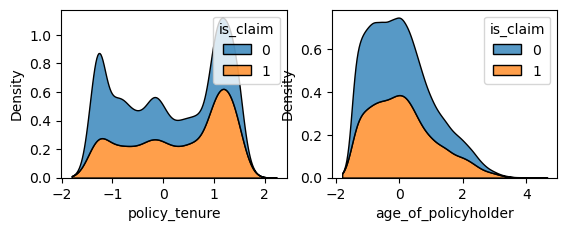

In [31]:
plt.subplot(2,2,1)
sns.kdeplot(data=train, x="policy_tenure", hue="is_claim", multiple="stack", common_norm=False)

plt.subplot(2,2,2)
sns.kdeplot(data=train, x="age_of_policyholder", hue="is_claim", multiple="stack", common_norm=False)

### Correlation Matrix

The purpose of a correlation matrix is to provide a comprehensive overview of the relationships between multiple variables in a dataset.

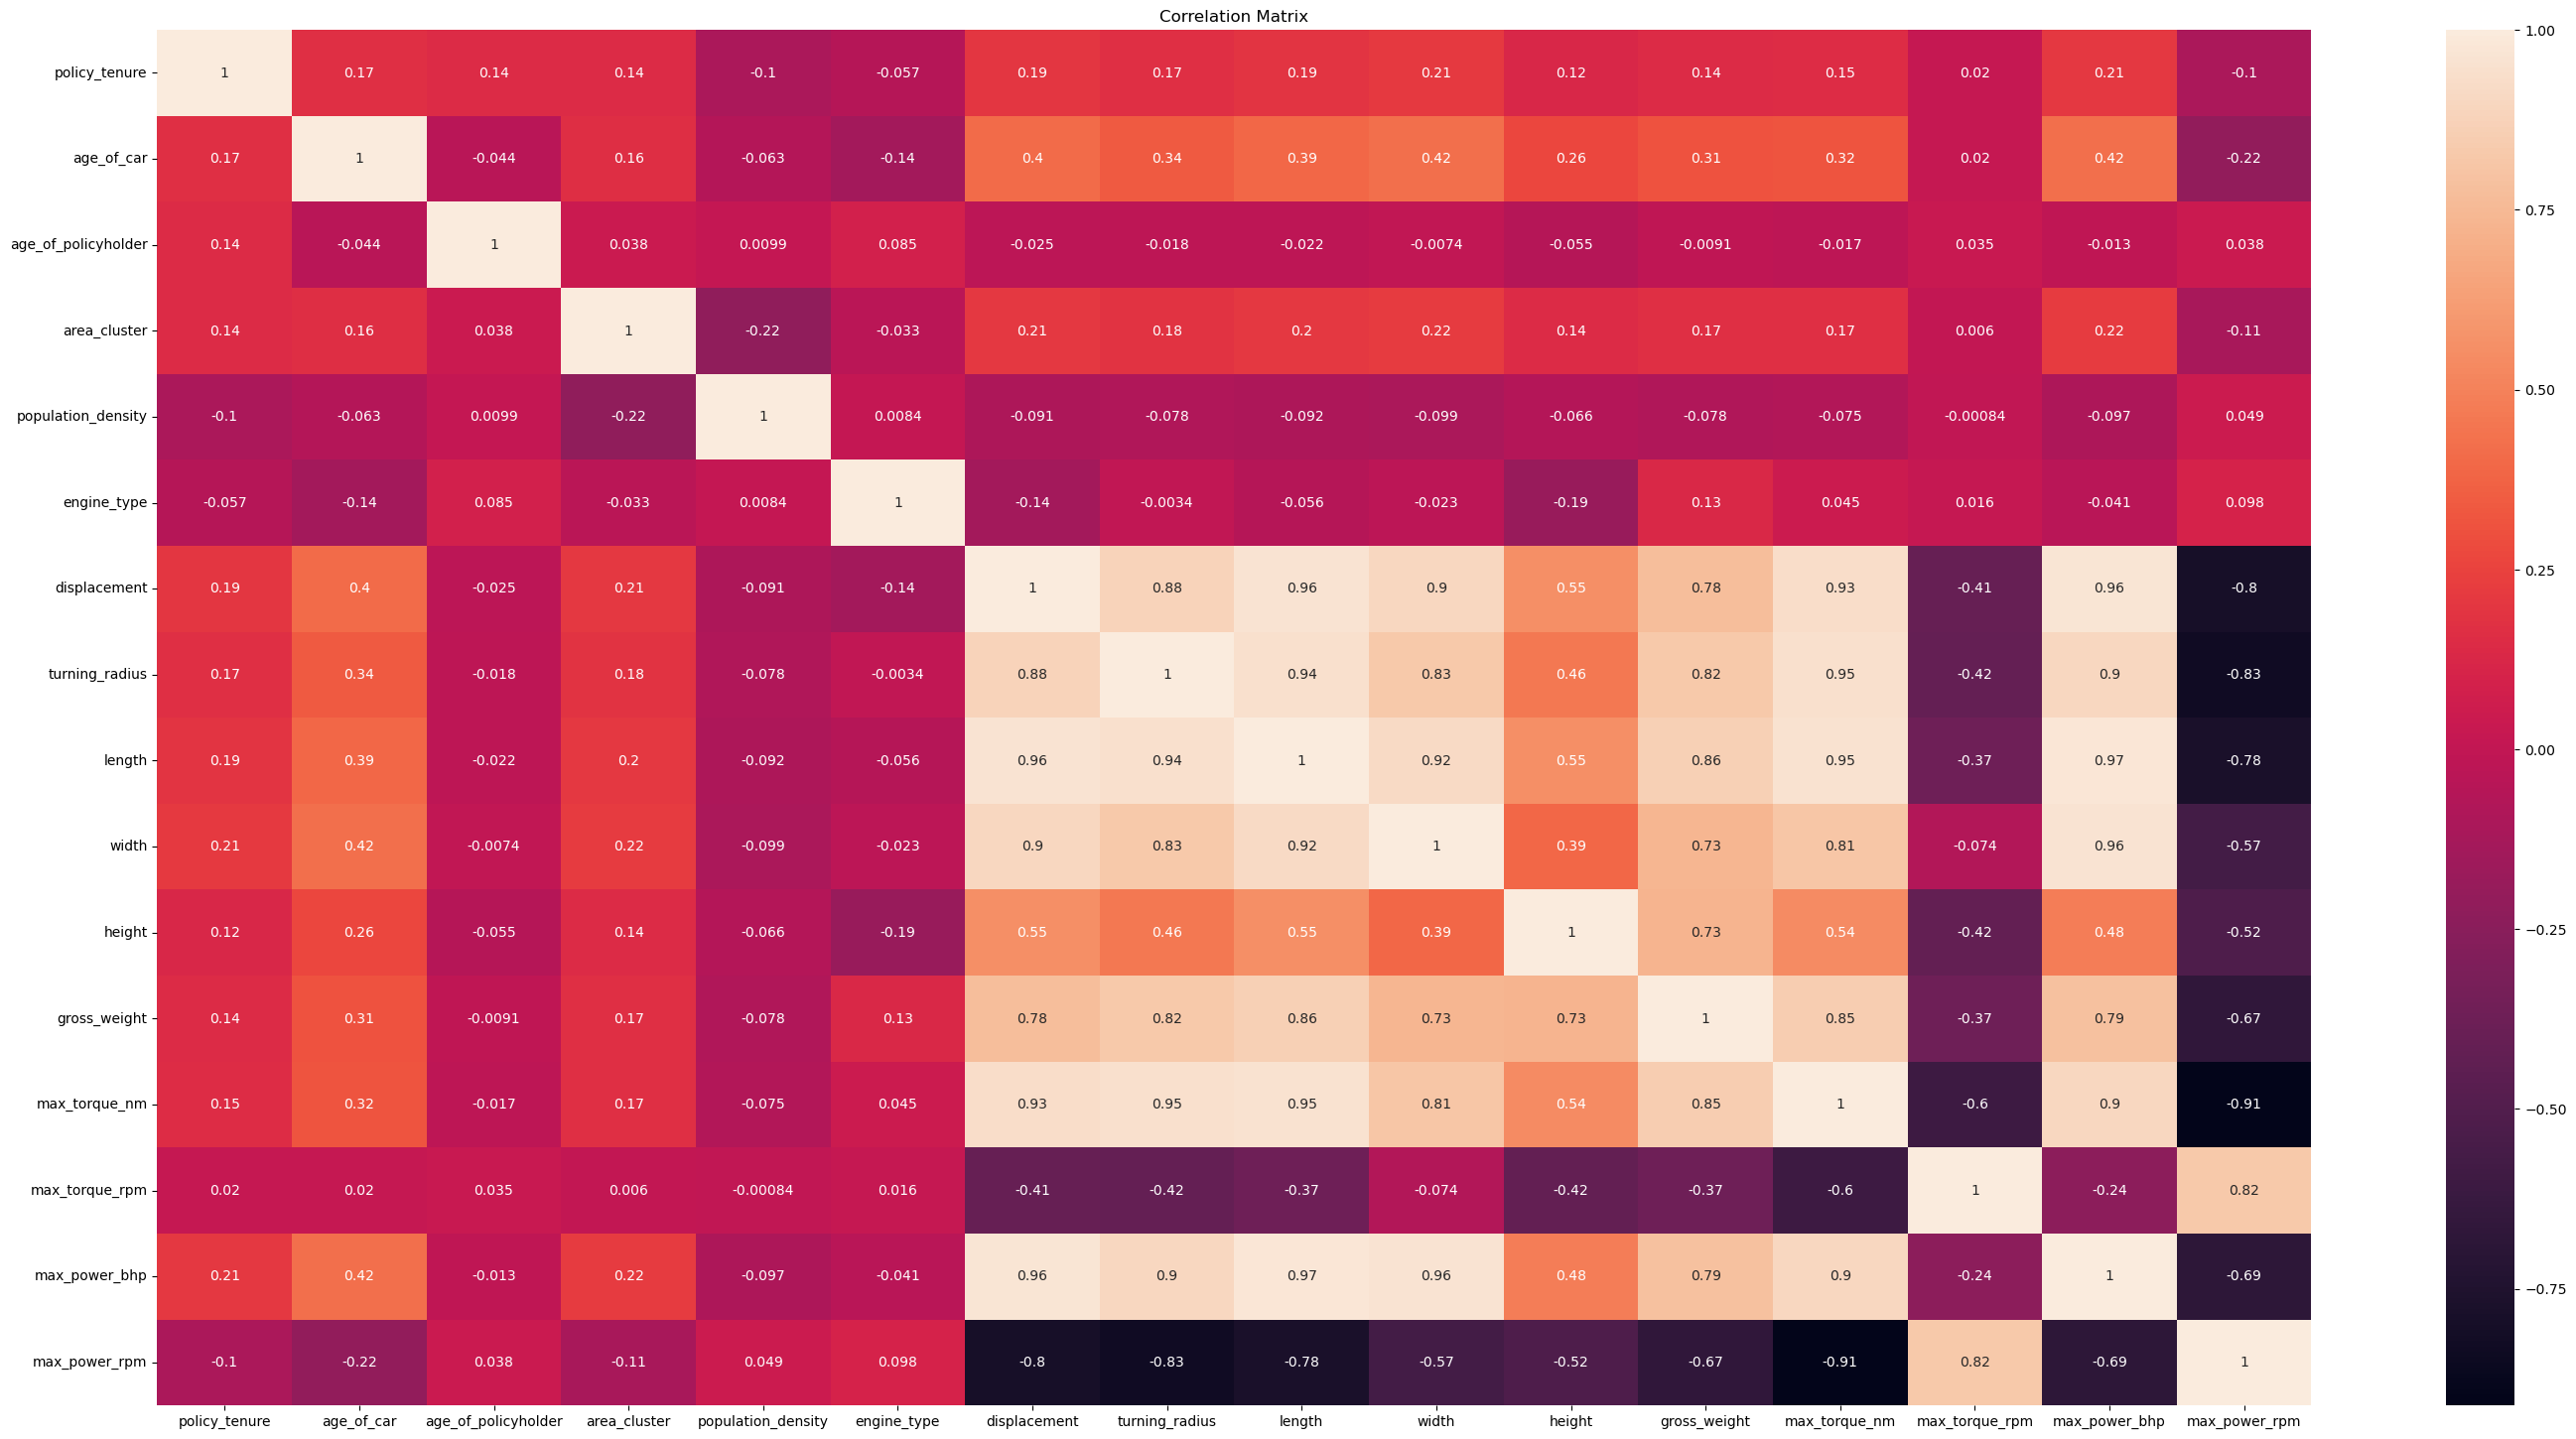

In [32]:
plt.figure(figsize=(35,18))
sns.heatmap(train.corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

### Sampling

Under sampling and over sampling are two common techniques used in imbalanced classification problems where the distribution of classes is significantly uneven. These techniques aim to address the imbalance and improve the performance of machine learning models.

In [33]:
data = train.copy()
encoders = []

for columns in data.columns:
    if dict(data.dtypes)[columns] == 'object':    
        encoder = sklearn.preprocessing.LabelEncoder()
        data[columns] = encoder.fit_transform(data[columns])
        encoders.append(encoder)

Original Data:

Split the training dataset into features (x) and the target variable (y).

In [34]:
x = data.drop('is_claim', axis=1)
y = data['is_claim']

Under sampling:

In [35]:
us = RandomUnderSampler()
x_us, y_us = us.fit_resample(x,y)

Over sampling:

In [ ]:
os = SMOTE()
x_os, y_os = os.fit_resample(x,y)

In [ ]:
print("Original sample size:\t{}".format(x.shape))
print("Under sample size:\t{}".format(x_us.shape))
print("Under sample size:\t{}".format(x_os.shape))

### Feature Selection

#### Original

##### Mutuals

Higher the mutual, more impactful the feature is.

In [67]:
mutual = mutual_info_classif(x,y)
mutual = pd.Series(mutual)
mutual.index = x.columns
pd.DataFrame(mutual.sort_values(ascending=False), columns=['Mutual information']).head(20)

,Mutual information
is_speed_alert,0.012545
is_power_door_locks,0.012376
transmission_type,0.011993
is_parking_sensors,0.011735
steering_type,0.011282
is_ecw,0.011274
cylinder,0.011051
is_central_locking,0.010389
is_power_steering,0.010259
rear_brakes_type,0.009758


In [68]:
selection = SelectKBest(score_func=mutual_info_classif, k=20).fit(x,y)
selection_bool = selection.get_support()
x_selected = x[x.columns[selection_bool]]
x_selected.columns

Index(['fuel_type', 'airbags', 'is_adjustable_steering', 'is_parking_sensors',
       'is_parking_camera', 'rear_brakes_type', 'cylinder',
       'transmission_type', 'steering_type', 'width', 'is_front_fog_lights',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert'],
      dtype='object')

##### P_value

Independent two sample test. 'scipy.stats.ttest_ind()' is used to determine whether there is a significant difference between the means of two independent samples.

In [69]:
numeric = [feature for feature in numerical if feature in x.columns]
pvalue = []

for column in numeric:
    x1 = train.loc[(train.is_claim == 0), column]
    x2 = train.loc[(train.is_claim == 1), column]
    _,pval = scipy.stats.ttest_ind(x1,x2)
    print(column,pval)
    pvalue.append(pval)

policy_tenure 8.505682164999909e-82
age_of_car 6.767599753776444e-11
age_of_policyholder 5.398481439143055e-08
area_cluster 1.55690688616874e-05
population_density 1.5141589205464591e-05
engine_type 0.554874043639796
displacement 0.0533777525143317
turning_radius 0.46411140824614494
length 0.10064582514721385
width 0.013658272321977163
height 0.6932990896284829
gross_weight 0.30943713703159087
max_torque_nm 0.2650273678679732
max_torque_rpm 0.2657182851334245
max_power_bhp 0.05355515467546841
max_power_rpm 0.9574950827552793


A small p-value (typically less than 0.05) suggests evidence against the null hypothesis and indicates a significant difference between the means of the two samples.

In [70]:
value = pd.Series(pvalue)
value.index = numeric
value.sort_values(ascending=True)
value[value < 0.05]

policy_tenure          8.505682e-82
age_of_car             6.767600e-11
age_of_policyholder    5.398481e-08
area_cluster           1.556907e-05
population_density     1.514159e-05
width                  1.365827e-02
dtype: float64

##### Chi-square

The chi-square test is a statistical test used to determine whether there is a significant association or dependency between categorical variables.

In [71]:
cols = x.loc[:, [feature for feature in categorical if feature in x.columns]]

In [72]:
values = chi2(cols, y)
values

(array([3.33598265, 3.80887604, 0.10264983, 0.39723146, 4.55606543,
        0.04121422, 0.16612365, 0.01893882, 0.01291547, 4.03821295,
        0.01213933, 0.0053912 , 4.35834652, 3.49848702, 0.29125136,
        0.29125136, 0.28090697, 3.20860545, 0.77515624, 0.77515624,
        0.00511456, 2.83350518, 2.24523244, 0.77515624, 0.01847151,
        0.72520867]),
 array([0.06777991, 0.05098165, 0.74867261, 0.52852252, 0.03280235,
        0.83912499, 0.68358007, 0.89054202, 0.90951824, 0.0444809 ,
        0.91226771, 0.94146809, 0.03682803, 0.06142492, 0.58941974,
        0.58941974, 0.59610737, 0.07325189, 0.37862664, 0.37862664,
        0.94298698, 0.09231667, 0.13402677, 0.37862664, 0.89189249,
        0.39444067]))

In [73]:
chi = pd.Series(values[1])
chi.index = cols.columns
chi.sort_values(ascending=True)[chi.sort_values(ascending=True)<0.05].index

Index(['is_adjustable_steering', 'steering_type', 'cylinder'], dtype='object')

<Axes: >

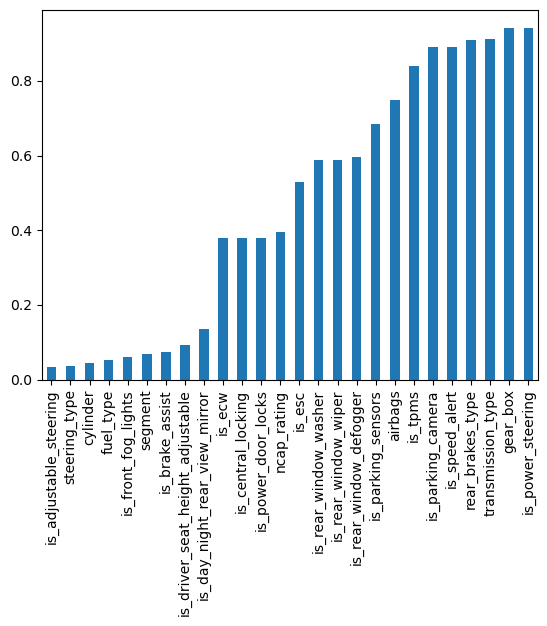

In [74]:
chi.sort_values(ascending=True).plot(kind='bar')

##### Selected Features

The selected features will be combination of p_value and chi square features.

In [75]:
cat = [feature for feature in chi[chi < 0.05].index]
num = [feature for feature in value[value < 0.05].index]

In [76]:
original_features = cat + num
original_features

['is_adjustable_steering',
 'cylinder',
 'steering_type',
 'policy_tenure',
 'age_of_car',
 'age_of_policyholder',
 'area_cluster',
 'population_density',
 'width']

#### Undersample

##### Mutuals

Higher the mutual, more impactful the feature is.

In [77]:
mutual = mutual_info_classif(x_us,y_us)
mutual = pd.Series(mutual)
mutual.index = x_us.columns
pd.DataFrame(mutual.sort_values(ascending=False), columns=['Mutual information']).head(20)

,Mutual information
policy_tenure,0.015403
is_parking_camera,0.014523
width,0.013170
age_of_car,0.011635
max_power_bhp,0.010899
gross_weight,0.009309
is_brake_assist,0.009025
cylinder,0.008969
max_power_rpm,0.008472
is_driver_seat_height_adjustable,0.008262


In [78]:
selection = SelectKBest(score_func=mutual_info_classif, k=20).fit(x_us,y_us)
selection_bool = selection.get_support()
x_selected = x_us[x_us.columns[selection_bool]]
x_selected.columns

Index(['policy_tenure', 'age_of_car', 'area_cluster', 'population_density',
       'segment', 'fuel_type', 'airbags', 'is_adjustable_steering',
       'is_parking_sensors', 'rear_brakes_type', 'is_front_fog_lights',
       'is_power_door_locks', 'is_central_locking', 'is_power_steering',
       'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert',
       'ncap_rating', 'max_torque_nm', 'max_power_bhp'],
      dtype='object')

##### P_value

Independent two sample test. 'scipy.stats.ttest_ind()' is used to determine whether there is a significant difference between the means of two independent samples.

In [93]:
numeric = [feature for feature in numerical if feature in x_us.columns]
pvalue = []

for column in numeric:
    x1 = train.loc[(train.is_claim == 0), column]
    x2 = train.loc[(train.is_claim == 1), column]
    _,pval = scipy.stats.ttest_ind(x1,x2)
    print(column,pval)
    pvalue.append(pval)

policy_tenure 8.505682164999909e-82
age_of_car 6.767599753776444e-11
age_of_policyholder 5.398481439143055e-08
area_cluster 1.55690688616874e-05
population_density 1.5141589205464591e-05
engine_type 0.554874043639796
displacement 0.0533777525143317
turning_radius 0.46411140824614494
length 0.10064582514721385
width 0.013658272321977163
height 0.6932990896284829
gross_weight 0.30943713703159087
max_torque_nm 0.2650273678679732
max_torque_rpm 0.2657182851334245
max_power_bhp 0.05355515467546841
max_power_rpm 0.9574950827552793


A small p-value (typically less than 0.05) suggests evidence against the null hypothesis and indicates a significant difference between the means of the two samples.

In [94]:
value = pd.Series(pvalue)
value.index = numeric
value.sort_values(ascending=True)
value[value < 0.05]

policy_tenure          8.505682e-82
age_of_car             6.767600e-11
age_of_policyholder    5.398481e-08
area_cluster           1.556907e-05
population_density     1.514159e-05
width                  1.365827e-02
dtype: float64

##### Chi square

The chi-square test is a statistical test used to determine whether there is a significant association or dependency between categorical variables.

In [81]:
cols = x_us.loc[:, [feature for feature in categorical if feature in x_us.columns]]

In [82]:
values = chi2(cols, y_us)
values

(array([4.84143399, 2.29504742, 0.66063301, 2.43611953, 3.85465243,
        1.43184422, 0.19053584, 0.04975812, 0.43614794, 3.18840885,
        0.50833672, 0.80760626, 0.78846154, 3.34957676, 2.24047059,
        2.24047059, 0.9231065 , 4.42247027, 1.09411331, 1.09411331,
        0.01365747, 2.69227283, 0.39616175, 1.09411331, 0.01936525,
        0.38478528]),
 array([0.02778378, 0.12978725, 0.41633656, 0.11856922, 0.0496082 ,
        0.2314637 , 0.66247102, 0.8234847 , 0.50898756, 0.07416216,
        0.47585976, 0.36882891, 0.37456573, 0.0672223 , 0.13444006,
        0.13444006, 0.33666063, 0.03546865, 0.29556163, 0.29556163,
        0.90696689, 0.10083589, 0.52907817, 0.29556163, 0.88932444,
        0.5350533 ]))

In [84]:
chi = pd.Series(values[1])
chi.index = cols.columns
chi.sort_values(ascending=True)[chi.sort_values(ascending=True)<0.05].index

Index(['segment', 'is_brake_assist', 'is_adjustable_steering'], dtype='object')

<Axes: >

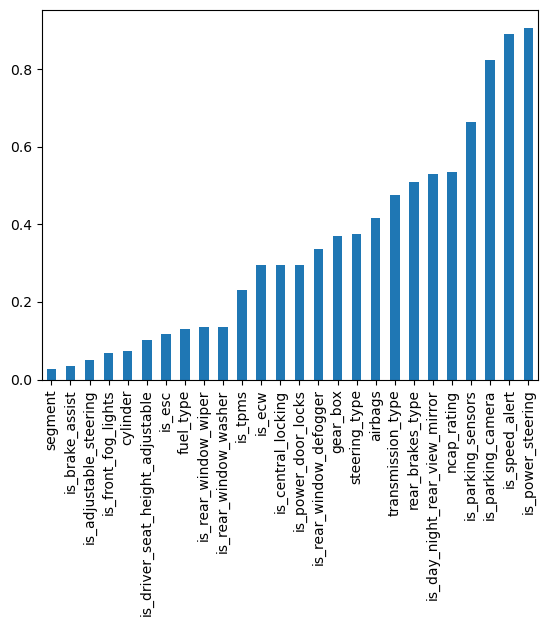

In [85]:
chi.sort_values(ascending=True).plot(kind='bar')

##### Features Selected

The selected features will be combination of p_value and chi square features.

In [87]:
cat = [feature for feature in chi[chi < 0.05].index]
num = [feature for feature in value[value < 0.05].index]

In [88]:
undersample_features = cat + num
undersample_features

['segment',
 'is_adjustable_steering',
 'is_brake_assist',
 'policy_tenure',
 'age_of_car',
 'age_of_policyholder',
 'area_cluster',
 'population_density',
 'width']

#### Oversample

##### Mutuals

Higher the mutual, more impactful the feature is.

In [ ]:
mutual = mutual_info_classif(x_os,y_os)
mutual = pd.Series(mutual)
mutual.index = x_os.columns
pd.DataFrame(mutual.sort_values(ascending=False), columns=['Mutual information']).head(20)

In [ ]:
selection = SelectKBest(score_func=mutual_info_classif, k=20).fit(x_os,y_os)
selection_bool = selection.get_support()
x_selected = x_os[x_us.columns[selection_bool]]
x_selected.columns

##### P_value

Independent two sample test. 'scipy.stats.ttest_ind()' is used to determine whether there is a significant difference between the means of two independent samples.

In [ ]:
numeric = [feature for feature in numerical if feature in x_os.columns]
pvalue = []

for column in numeric:
    x1=train.loc[(train.is_claim == 0), column]
    x2=train.loc[(train.is_claim == 1), column]
    _,pval = scipy.stats.ttest_ind(x1,x2)
    print(column,pval)
    pvalue.append(pval)

A small p-value (typically less than 0.05) suggests evidence against the null hypothesis and indicates a significant difference between the means of the two samples.

In [ ]:
value = pd.Series(pvalue)
value.index = numeric
value.sort_values(ascending=True)
value[value < 0.05]

##### Chi square

The chi-square test is a statistical test used to determine whether there is a significant association or dependency between categorical variables.

In [ ]:
cols = x_os.loc[:, [feature for feature in categorical if feature in x_os.columns]]

In [ ]:
values = chi2(cols, y_os)
values

In [ ]:
chi = pd.Series(values[1])
chi.index = cols.columns
chi.sort_values(ascending=True)[chi.sort_values(ascending=True)<0.05].index

In [ ]:
chi.sort_values(ascending=True).plot(kind='bar')

##### Features Selected

The selected features will be combination of p_value and chi square features.

In [ ]:
cat = [feature for feature in chi[chi < 0.05].index]
num = [feature for feature in value[value < 0.05].index]

In [ ]:
oversample_features = cat + num
oversample_features

# Supervised Learning

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=2)
x_utrain, x_utest, y_utrain, y_utest = train_test_split(x_us,y_us,test_size=0.2,random_state=2)
x_otrain, x_otest, y_otrain, y_otest = train_test_split(x_os,y_os,test_size=0.2,random_state=2)

##### Original

In [96]:
algorithms = {
    'Logistic Regression': LogisticRegression(),
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boost': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'Neural Networks': MLPClassifier(),
}

models = pd.DataFrame(columns=['model name', 'accuracy', 'recall', 'precision', 'f1 score'])

for algorithm, name in list(zip(algorithms.values(), algorithms.keys())):
    algorithm.fit(x_train, y_train)
    y_pred = algorithm.predict(x_test)
    t = {
        'model name' : name,
        'accuracy' : accuracy_score(y_test,y_pred),
        'recall' : recall_score(y_test, y_pred, zero_division=1),
        'precision' : precision_score(y_test, y_pred, zero_division=1),
        'f1 score' : f1_score(y_test, y_pred, zero_division=1),
    }

    models = models.append(t, ignore_index=True)
models = models.sort_values(by='f1 score', ascending=False)
models

,model name,accuracy,recall,precision,f1 score
1,Decision Trees,0.873039,0.094067,0.070652,0.080695
2,Random Forest,0.936905,0.004342,0.058824,0.008086
0,Logistic Regression,0.940763,0.000000,1.000000,0.000000
3,Gradient Boost,0.940592,0.000000,0.000000,0.000000
4,XGBoost,0.940592,0.000000,0.000000,0.000000
5,Neural Networks,0.940763,0.000000,1.000000,0.000000


##### Undersample

In [ ]:
algorithms = {
    'Logistic Regression': LogisticRegression(),
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boost': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'Neural Networks': MLPClassifier(),
}

models = pd.DataFrame(columns=['model name', 'accuracy', 'recall', 'precision', 'f1 score'])

for algorithm, name in list(zip(algorithms.values(), algorithms.keys())):
    algorithm.fit(x_utrain, y_utrain)
    y_pred = algorithm.predict(x_test)
    t = {
        'model name' : name,
        'accuracy' : accuracy_score(y_test,y_pred),
        'recall' : recall_score(y_test, y_pred, zero_division=1),
        'precision' : precision_score(y_test, y_pred, zero_division=1),
        'f1 score' : f1_score(y_test, y_pred, zero_division=1),
    }

    models = models.append(t, ignore_index=True)
models = models.sort_values(by='f1 score', ascending=False)
models

##### Oversample

In [ ]:
algorithms = {
    'Logistic Regression': LogisticRegression(),
    'Decision Trees': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boost': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'Neural Networks': MLPClassifier(),
}

models = pd.DataFrame(columns=['model name', 'accuracy', 'recall', 'precision', 'f1 score'])

for algorithm, name in list(zip(algorithms.values(), algorithms.keys())):
    algorithm.fit(x_otrain, y_otrain)
    y_pred = algorithm.predict(x_test)
    t = {
        'model name' : name,
        'accuracy' : accuracy_score(y_test,y_pred),
        'recall' : recall_score(y_test, y_pred, zero_division=1),
        'precision' : precision_score(y_test, y_pred, zero_division=1),
        'f1 score' : f1_score(y_test, y_pred, zero_division=1),
    }

    models = models.append(t, ignore_index=True)
models = models.sort_values(by='f1 score', ascending=False)
models

## Logistic Regression

Logistic regression is a statistical model used for binary classification, where the goal is to predict the probability of an event occurring based on a set of input variables or features. It is a commonly used algorithm in machine learning and statistics, particularly in cases where the dependent variable is categorical.

In [ ]:
algorithm = LogisticRegression(max_iter = 1000)

#  Original
algorithm.fit(x_train, y_train)

train_prediction = algorithm.predict(x_train)
acc_train = accuracy_score(train_prediction, y_train)
print("Original Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_test)
acc_test = accuracy_score(test_prediction, y_test)
print("Original Test Accuracy:",acc_test)

#  Undersample
algorithm.fit(x_utest, y_utest)

train_prediction = algorithm.predict(x_utrain)
acc_train = accuracy_score(train_prediction, y_utrain)
print("Undersample Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_utest)
acc_test = accuracy_score(test_prediction, y_utest)
print("Undersample Test Accuracy:",acc_test)

#  Oversample
algorithm.fit(x_otest, y_otest)

train_prediction = algorithm.predict(x_otrain)
acc_train = accuracy_score(train_prediction, y_otrain)
print("Undersample Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_otest)
acc_test = accuracy_score(test_prediction, y_otest)
print("Undersample Test Accuracy:",acc_test)

## Decision Trees

A decision tree is a popular machine learning algorithm that can be used for both regression and classification tasks. The decision tree algorithm learns to make these decisions based on the patterns in the training data.

In [ ]:
algorithm = DecisionTreeClassifier()

#  Original
algorithm.fit(x_train, y_train)

train_prediction = algorithm.predict(x_train)
acc_train = accuracy_score(train_prediction, y_train)
print("Original Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_test)
acc_test = accuracy_score(test_prediction, y_test)
print("Original Test Accuracy:",acc_test)

#  Undersample
algorithm.fit(x_utest, y_utest)

train_prediction = algorithm.predict(x_utrain)
acc_train = accuracy_score(train_prediction, y_utrain)
print("Undersample Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_utest)
acc_test = accuracy_score(test_prediction, y_utest)
print("Undersample Test Accuracy:",acc_test)

#  Oversample
algorithm.fit(x_otest, y_otest)

train_prediction = algorithm.predict(x_otrain)
acc_train = accuracy_score(train_prediction, y_otrain)
print("Undersample Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_otest)
acc_test = accuracy_score(test_prediction, y_otest)
print("Undersample Test Accuracy:",acc_test)

## Random Forest

Random Forests is a machine learning algorithm that combines the power of decision trees and ensemble learning. Random Forests construct multiple decision trees and aggregate their predictions to make more accurate and robust predictions.

In [ ]:
algorithm = RandomForestClassifier()

#  Original
algorithm.fit(x_train, y_train)

train_prediction = algorithm.predict(x_train)
acc_train = accuracy_score(train_prediction, y_train)
print("Original Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_test)
acc_test = accuracy_score(test_prediction, y_test)
print("Original Test Accuracy:",acc_test)

#  Undersample
algorithm.fit(x_utest, y_utest)

train_prediction = algorithm.predict(x_utrain)
acc_train = accuracy_score(train_prediction, y_utrain)
print("Undersample Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_utest)
acc_test = accuracy_score(test_prediction, y_utest)
print("Undersample Test Accuracy:",acc_test)

#  Oversample
algorithm.fit(x_otest, y_otest)

train_prediction = algorithm.predict(x_otrain)
acc_train = accuracy_score(train_prediction, y_otrain)
print("Undersample Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_otest)
acc_test = accuracy_score(test_prediction, y_otest)
print("Undersample Test Accuracy:",acc_test)

## Gradient Boost

Gradient Boosting is a powerful machine learning algorithm that belongs to the family of ensemble methods, which combines multiple weak learners to create a strong learner. 

In [ ]:
algorithm = GradientBoostingClassifier()

#  Original
algorithm.fit(x_train, y_train)

train_prediction = algorithm.predict(x_train)
acc_train = accuracy_score(train_prediction, y_train)
print("Original Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_test)
acc_test = accuracy_score(test_prediction, y_test)
print("Original Test Accuracy:",acc_test)

#  Undersample
algorithm.fit(x_utest, y_utest)

train_prediction = algorithm.predict(x_utrain)
acc_train = accuracy_score(train_prediction, y_utrain)
print("Undersample Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_utest)
acc_test = accuracy_score(test_prediction, y_utest)
print("Undersample Test Accuracy:",acc_test)

#  Oversample
algorithm.fit(x_otest, y_otest)

train_prediction = algorithm.predict(x_otrain)
acc_train = accuracy_score(train_prediction, y_otrain)
print("Undersample Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_otest)
acc_test = accuracy_score(test_prediction, y_otest)
print("Undersample Test Accuracy:",acc_test)

## XGBoost

XGBoost, short for Extreme Gradient Boosting, is an optimized implementation of the gradient boosting algorithm. It is a highly efficient and scalable machine learning algorithm known for its exceptional performance in a wide range of tasks, including regression, classification, and ranking problems.

In [ ]:
algorithm = XGBClassifier()

#  Original
algorithm.fit(x_train, y_train)

train_prediction = algorithm.predict(x_train)
acc_train = accuracy_score(train_prediction, y_train)
print("Original Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_test)
acc_test = accuracy_score(test_prediction, y_test)
print("Original Test Accuracy:",acc_test)

#  Undersample
algorithm.fit(x_utest, y_utest)

train_prediction = algorithm.predict(x_utrain)
acc_train = accuracy_score(train_prediction, y_utrain)
print("Undersample Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_utest)
acc_test = accuracy_score(test_prediction, y_utest)
print("Undersample Test Accuracy:",acc_test)

#  Oversample
algorithm.fit(x_otest, y_otest)

train_prediction = algorithm.predict(x_otrain)
acc_train = accuracy_score(train_prediction, y_otrain)
print("Undersample Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_otest)
acc_test = accuracy_score(test_prediction, y_otest)
print("Undersample Test Accuracy:",acc_test)

## Neural Networks

Neural networks, also known as artificial neural networks or deep neural networks, are a class of machine learning models inspired by the structure and functioning of the human brain. They are designed to recognize patterns, learn from data, and make predictions or decisions.

In [ ]:
algorithm = MLPClassifier()

#  Original
algorithm.fit(x_train, y_train)

train_prediction = algorithm.predict(x_train)
acc_train = accuracy_score(train_prediction, y_train)
print("Original Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_test)
acc_test = accuracy_score(test_prediction, y_test)
print("Original Test Accuracy:",acc_test)

#  Undersample
algorithm.fit(x_utest, y_utest)

train_prediction = algorithm.predict(x_utrain)
acc_train = accuracy_score(train_prediction, y_utrain)
print("Undersample Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_utest)
acc_test = accuracy_score(test_prediction, y_utest)
print("Undersample Test Accuracy:",acc_test)

#  Oversample
algorithm.fit(x_otest, y_otest)

train_prediction = algorithm.predict(x_otrain)
acc_train = accuracy_score(train_prediction, y_otrain)
print("Undersample Training Accuracy:",acc_train)

test_prediction = algorithm.predict(x_otest)
acc_test = accuracy_score(test_prediction, y_otest)
print("Undersample Test Accuracy:",acc_test)